In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath
import networkx as nx

from metal.label_model import LabelModel
from metal.label_model.graph_utils import JunctionTree
from synthetic.generate_spa import (
    ChainDependencies,
    TreeDependencies,
    ClusterDependencies,
    DataGenerator
)
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


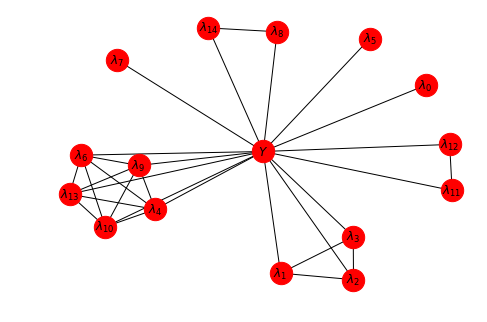

In [2]:
M = 15
N_CLUSTERS = 10
deps_graph = ClusterDependencies(M, N_CLUSTERS)
# deps_graph = ChainDependencies(M)
deps_graph.draw()

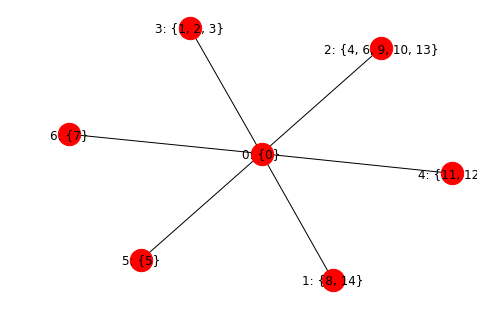

In [3]:
N = 1000 # Not used yet...
K = 2
HIGHER_ORDER_CLIQUES = True

data = DataGenerator(
    N,
    M,
    k=K,
    abstains=False,
    deps_graph=deps_graph,
    higher_order_cliques=HIGHER_ORDER_CLIQUES
)
data.jt.draw()

### Computing entries across cliques

Say we want to compute marginals involving neighboring cliques $C_1$ and $C_2$; we have:
$$
P(C_1, C_2)
= P(C_1, C_2|S_{1,2}) P(S_{1,2})
= P(C_1|S_{1,2}) P(C_2|S_{1,2}) P(S_{1,2})
= \frac{P(C_1) P(C_2) }{ P(S_{1,2}) }
$$

In [4]:
query = {0:2, 1:1, M:1}

In [5]:
%time data.P_marginal(query)

CPU times: user 3.37 ms, sys: 69 µs, total: 3.44 ms
Wall time: 3.57 ms


0.20410592266373628

In [6]:
%%time
p = data.P_marginal_brute_force(query)
print(p)

0.2041059226637349
CPU times: user 3.05 s, sys: 11.3 ms, total: 3.06 s
Wall time: 3.07 s


In [7]:
data.P_marginal({M:1})

0.7737584010109303

In [8]:
data.P_marginal_brute_force({M:1})

0.7737584010109254

## Trying to recover the clique marginals

We start with:
$$
K_O = \Sigma_O^{-1} + \Sigma_O^{-1}\Sigma_{OH} \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1} \Sigma_{OH}^T\Sigma_O^{-1}
$$
and set:
$$
ZZ^T = \Sigma_O^{-1}\Sigma_{OH} \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1} \Sigma_{OH}^T\Sigma_O^{-1}
$$

Let $JJ^T = \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1}$; then $Z = \Sigma_O^{-1}\Sigma_{OH}J$.

Now our question is: suppose we've estimated $Z$, how do we recover $\Sigma_{OH}$ (which **note is not $\mu$, but we can recover $\mu$ directly from this given the labeling rates and class balance**).
We start by trying to recover an intermediate quantity:
$$
Q 
= \Sigma_{OH} \Sigma_H^{-1} \Sigma_{OH}^T
= \left( \Sigma_O Z J^{-1} \right) \Sigma_H^{-1}  \left( \Sigma_O Z J^{-1} \right)^T
= \Sigma_O Z J^{-1} \Sigma_H^{-1} J^{-T} Z^T \Sigma_O
= \Sigma_O Z \left( J^T \Sigma_H J \right)^{-1} Z^T \Sigma_O
$$

Now we need to recover $J^T\Sigma_H J$... start by noting that:
$$
\Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH}
=
J^{-T}Z^T\Sigma_O\Sigma_O^{-1}\Sigma_OZJ^{-1}
=
J^{-T}Z^T\Sigma_OZJ^{-1}
$$
and
$$
JJ^T
= \left( \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH} \right)^{-1}
$$
and thus
$$
(JJ^T)^{-1}
= \Sigma_H - \Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH}
$$
and so
$$
J^T\Sigma_HJ
= I + J^T\Sigma_{OH}^T\Sigma_O^{-1}\Sigma_{OH}J
$$

Putting these two expressions together we have:
$$
J^T\Sigma_HJ
= I + Z^T\Sigma_OZ
$$

So finally, we have:
$$
Q 
= \Sigma_O Z \left( I + Z^T\Sigma_OZ \right)^{-1} Z^T \Sigma_O
$$

In [9]:
%time sigma_O = data.get_sigma_O()

CPU times: user 3.07 s, sys: 15.7 ms, total: 3.09 s
Wall time: 3.1 s


In [10]:
np.linalg.cond(sigma_O)

19.780296931572558

In [11]:
class_balance = data.get_class_balance()
class_balance

array([0.7737584, 0.2262416])

In [12]:
lm = LabelModel(k=2)

lm.train(
    sigma_O=sigma_O,
    junction_tree=data.jt,
    class_balance=class_balance,
    lr=0.001,
    n_epochs=10000,
    print_every=1000
)

Estimating Z...
[E:0]	Train Loss: 82.234
[E:1000]	Train Loss: 0.000
[E:2000]	Train Loss: 0.000
[E:3000]	Train Loss: 0.000
[E:4000]	Train Loss: 0.000
[E:5000]	Train Loss: 0.000
[E:6000]	Train Loss: 0.000
[E:7000]	Train Loss: 0.000
[E:8000]	Train Loss: 0.000
[E:9000]	Train Loss: 0.000
[E:9999]	Train Loss: 0.000
Finished Training
Estimating \mu...
[E:0]	Train Loss: 2490.244
[E:1000]	Train Loss: 0.001
[E:2000]	Train Loss: 0.000
[E:3000]	Train Loss: 0.000
[E:4000]	Train Loss: 0.000
[E:5000]	Train Loss: 0.000
[E:6000]	Train Loss: 0.000
[E:7000]	Train Loss: 0.000
[E:8000]	Train Loss: 0.000
[E:9000]	Train Loss: 0.000
[E:9999]	Train Loss: 0.000
Finished Training


In [13]:
sigma_O_inv = np.linalg.inv(sigma_O)

sigma_H = data.P_marginal({M:2})

mu = data.get_mu()
mu_x = sigma_H * np.array([data.P_marginal(v) for i, v in data.jt.iter_observed()])
sigma_OH = mu - mu_x

sigma_OH

array([-0.01351343,  0.0038267 , -0.00879558, -0.0193804 ,  0.04012331,
        0.00549803,  0.02481791, -0.01536779,  0.00491417,  0.01609288,
        0.02922382, -0.03258345,  0.00193647,  0.01033909,  0.00828023,
        0.00609182,  0.01046378, -0.00462973, -0.01194337])

In [16]:
SIGN_FLIP = -1
mu_est = SIGN_FLIP * lm.mu.detach().numpy() + mu_x.reshape([-1,1])
np.hstack([mu_est, mu.reshape([-1, 1])])

array([[0.0855835 , 0.08743266],
       [0.10299537, 0.10247174],
       [0.08142347, 0.08262704],
       [0.11664734, 0.11929961],
       [0.17110518, 0.16561594],
       [0.10876698, 0.10801458],
       [0.15822081, 0.15482518],
       [0.11525587, 0.11735903],
       [0.1144161 , 0.11374366],
       [0.10916342, 0.1069618 ],
       [0.12534528, 0.1213473 ],
       [0.09406103, 0.09852042],
       [0.09949925, 0.09923422],
       [0.1507138 , 0.14929915],
       [0.09014402, 0.08901085],
       [0.05134295, 0.05050928],
       [0.01923945, 0.01780777],
       [0.02490627, 0.02553979],
       [0.05881037, 0.06044477]])

In [17]:
np.mean(np.abs(mu - mu_est.ravel()))

0.001928768624879703